In [1]:
import numpy as np
import matplotlib.pyplot as plt
import holoviews as hv
from tqdm import trange, tqdm
from numba import njit, prange
import datetime
import json
%pip install ipython-autotime
%load_ext autotime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.9 MB/s eta 0:00:00
time: 292 µs (started: 2023-11-25 01:46:50 +00:00)


In [8]:
def Q0(n, dt=0, Theta0=43, P0=100 ):
          return P0 *( np.sin( (2 * np.pi) * (n * dt)/ (Theta0) ) + 1)

def Q1(n, dt=0, Theta1=77, P1=100 ):
          return P1 *( np.sin( (2 * np.pi) * (n * dt)/ (Theta1) ) + 1)

time: 701 µs (started: 2023-11-25 02:00:27 +00:00)


In [9]:
def boundary_conditions(n, U):
    U[n,-1,:] = U[n, -2, :]
    U[n, :, -1] = U[n, :, -2]

time: 549 µs (started: 2023-11-25 02:00:29 +00:00)


In [10]:
def heat_source0(n, U, dt = 0, multiple = 1):
    ys = 20*multiple
    ye = 40*multiple
    xs = 5*multiple
    xe = 10*multiple
    Theta0 = 43
    P0 = 100
    cur = (n % 2)
    U[cur, ys:ye, xs:xe] += Q0(n, dt = dt, Theta0 = Theta0, P0 = P0) * dt

def heat_source1(n, U, dt = 0, multiple = 1):
    ys = 5 * multiple
    ye = 10 * multiple
    xs = 20 * multiple
    xe = 40 * multiple
    Theta1 = 77
    P1 = 100
    cur = (n % 2)
    U[cur, ys:ye, xs:xe] += Q1(n, dt = dt, Theta1 = Theta1, P1 = P1) * dt

time: 884 µs (started: 2023-11-25 02:00:30 +00:00)


In [11]:
@njit(parallel = True)
def diffuse_step(cur, U, D=0, dt=0, dx=0, N = 60):

    for i in prange(1, N-1):
      for j in range(1, N-1):

         U[cur, i, j] = U[-1, i, j] + (dt / dx**2 ) * D[i,j] * (U[-1, i+1, j] +
                          U[-1, i-1, j] +
                          U[-1, i, j+1] +
                          U[-1, i, j-1] -
                          4 * U[-1, i, j])

time: 778 µs (started: 2023-11-25 02:00:31 +00:00)


In [12]:
import numpy as np
from tqdm import trange
import datetime

def execute_for_N(N):
    # Задаем параметры модели
    Dmax = 1.0
    C = 0.1
    u_left = 0
    u_bottom = 0

    # Инициализация параметров сетки
    nx, ny = N, N
    dx = 60 / N
    dt = C * dx**2 / Dmax
    nt = int(600 / dt)

    # Инициализация массива U
    U = np.zeros((2, ny, nx))

    # Граничные условия
    U[:, 0, :] = u_bottom
    U[:, :, 0] = u_left

    # Инициализация массива D
    D = np.ones((ny, nx))
    multiple = int(N / 60)

    # Устанавливаем значения для зон с пониженной диффузией
    D[25 * multiple:35 * multiple, 15 * multiple:45 * multiple] = 0.01
    D[15 * multiple:45 * multiple, 25 * multiple:35 * multiple] = 0.01

    loc_diffusion_map = D.tolist()

    # Задаем координаты источников
    P0_ys, P0_ye = 20 * multiple, 40 * multiple
    P0_xs, P0_xe = 5 * multiple, 10 * multiple

    P1_ys, P1_ye = 5 * multiple, 10 * multiple
    P1_xs, P1_xe = 20 * multiple, 40 * multiple

    # Задаем координаты точек
    COORDS_OF_POINTS = [
    [20 * multiple, 20 * multiple],
   [40 * multiple, 20 * multiple],
    [40 * multiple, 40 * multiple],
    [20 * multiple, 40 * multiple]
    ]

    # Инициализация словаря для хранения результатов

    loc_points_data = [[], [], [], []]

    # Засекаем время начала выполнения
    now = datetime.datetime.now()

    # Итерации во времени
    for n in trange(1, nt):
        prev = n % 2
        cur = prev - 1

        heat_source0(cur, U, dt=dt, multiple=multiple)
        heat_source1(cur, U, dt=dt, multiple=multiple)

        diffuse_step(cur, U, D=D, dt=dt, dx=dx, N=N)
        boundary_conditions(cur, U)

        # Сохраняем значения
        for i in range(4):
            loc_points_data[i].append(U[cur,COORDS_OF_POINTS[i][0], COORDS_OF_POINTS[i][1]])





    # Сохраняем конечное состояние U в U_MAPS и результаты в PROB_VALUES
    loc_temp_map = U[-1].tolist()





    # Засекаем время окончания выполнения
    end = datetime.datetime.now()

    # Выводим время выполнения
    print(f'EX TIME FOR {N}: {end - now}')

    return [loc_diffusion_map, loc_temp_map, loc_points_data]




time: 2.08 ms (started: 2023-11-25 02:00:32 +00:00)


time: 37.2 s (started: 2023-11-25 01:56:15 +00:00)


In [7]:
N = [60, 120, 240]
data_60 = execute_for_N(60)


100%|██████████| 5999/5999 [00:01<00:00, 4278.26it/s]

EX TIME FOR 60: 0:00:01.409476
time: 1.41 s (started: 2023-11-25 01:57:26 +00:00)


In [13]:
for n in N:
  data = execute_for_N(n)

  with open(f'Diff{n}.json', 'w') as file:
    json.dump(data[0], file)
  with open(f'Temp{n}.json', 'w') as file:
    json.dump(data[1], file)
  with open(f'Points{n}.json', 'w') as file:
    json.dump(data[2], file)

100%|██████████| 5999/5999 [00:00<00:00, 6759.13it/s]


EX TIME FOR 60: 0:00:00.893597


100%|██████████| 23999/23999 [00:02<00:00, 8969.61it/s]


EX TIME FOR 120: 0:00:02.684752


100%|██████████| 95999/95999 [00:18<00:00, 5279.95it/s]


EX TIME FOR 240: 0:00:18.186920
time: 22.5 s (started: 2023-11-25 02:00:36 +00:00)


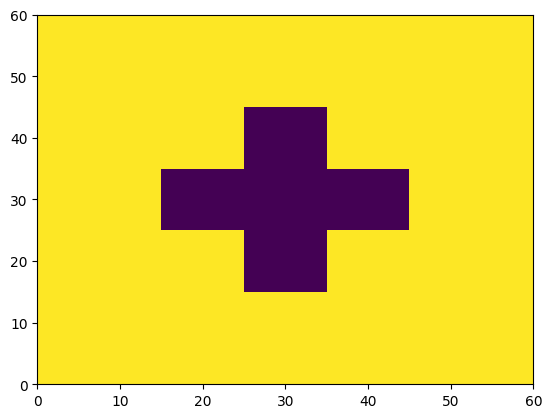

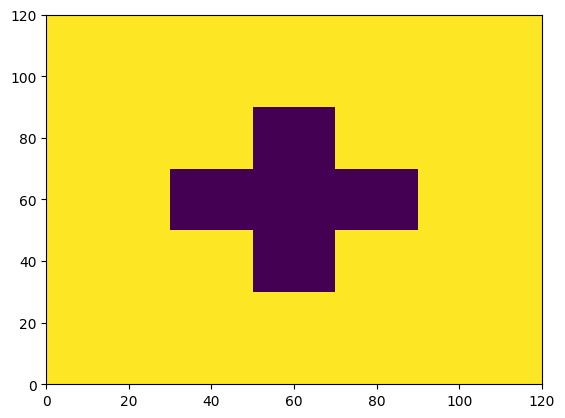

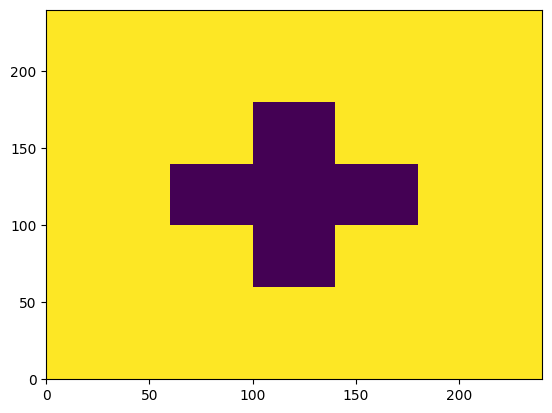

time: 574 ms (started: 2023-11-25 02:04:56 +00:00)


In [15]:
for n in N:
   with open(f'Diff{n}.json', 'r') as file:
      data = json.load(file)
      plt.pcolormesh(data)
      plt.show()



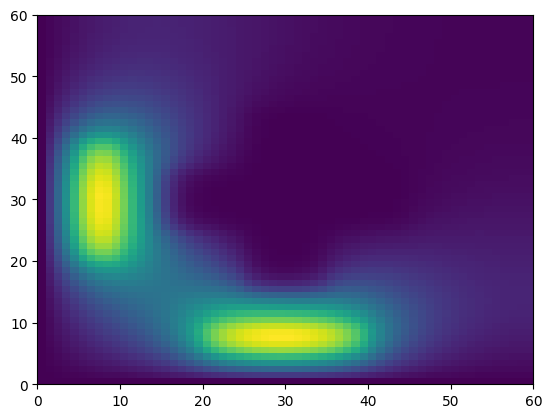

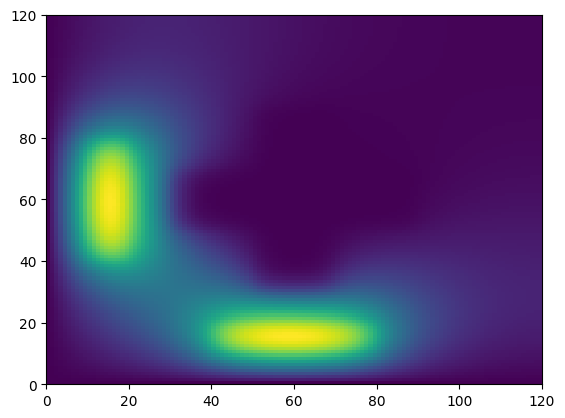

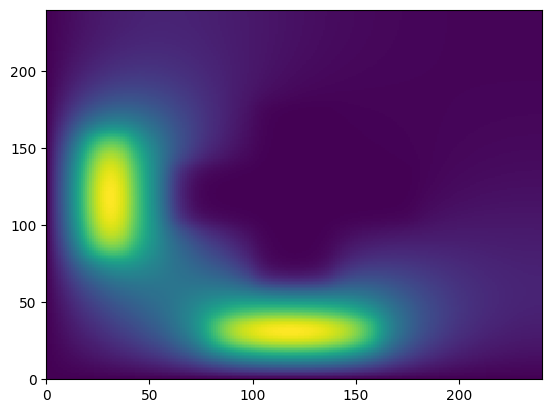

time: 742 ms (started: 2023-11-25 02:05:42 +00:00)


In [17]:
for n in N:
   with open(f'Temp{n}.json', 'r') as file:
      data = json.load(file)
      plt.pcolormesh(data)
      plt.pcolormesh(data)
      plt.show()